In [1]:
import itertools
import os
import subprocess
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
import mplhep as hep

parent_dir = Path(os.path.abspath("RunGPUSimulation_scan.ipynb")).parent.parent
sys.path.append(str(parent_dir))
from src.annealing_depth import plot_data_vs_sim

In [2]:
rc("text", usetex=True)
plt.style.use(hep.style.ROOT)

In [3]:
!nvidia-smi
!nvcc  -o radicals -x cu -lnvToolsExt -I ../CLI11/include ../src/solverRadicals.cu

Fri Jul 21 07:23:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:65:00.0 Off |                    0 |
| N/A   44C    P0               28W / 250W|      0MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!./radicals -h

Radical diffusion simulation
Usage: ./radicals [OPTIONS]

Options:
  -h,--help                   Print this help message and exit
  --diffCoeff FLOAT           Diffusion coefficient
  --radFormRate FLOAT         Radical formation rate
  --k1 FLOAT                  Rate of crosslinking
  --k2 FLOAT                  Rate of radical oxidation
  --doseRate FLOAT            Dose rate
  --irrTime INT               Irradiation time
  --totalTime INT             Total time
  --dimXYZ INT x 3            Dimensions X Y Z of the array
  --outputPrefix TEXT         Output file name
  -l,--limitedSave            Save only the middle slice for activity


In [10]:
def run_sim(D, R, k1, k2):
    """
    Run the simulation with the given parameters and save the maximum of
    the activity as function of time as a numpy array.

    Parameters
    ----------
    D : float
        Diffusion coefficient
    R : float
        Radical formation rate (includes the dose rate so it's Y*R)
    k1 : float
        Rate constant for the radical crosslinking reaction
    k2 : float
        Rate constant for the radical oxidation reaction

    Returns
    -------
    None
    """
    print(f"Processing D={D} R={R} k1={k1} k2={k2}")
    subprocess.run(
        [
            "./radicals",
            "--diffCoeff",
            str(D),
            "--radFormRate",
            str(R),
            "--k1",
            str(k1),
            "--k2",
            str(k2),
            "-l",
        ],
    )
    activity = np.fromfile("outputactivity.dat", dtype=np.float32)
    tDim = 20000
    xDim = 100
    activity = np.reshape(activity, (tDim, xDim))
    maximum = []
    times = range(10001, 20000)
    for time in times:
        maximum.append(np.argmax(activity[time, :]))
    times = np.array(times)
    times = times - times[0]
    maximum = np.array(maximum)
    maximum = maximum / 10
    label = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
    np.save(f"../data/sim_{label}", maximum)

In [91]:
D = 0.1
# R_arr = [round(0.0001 * i, 4) for i in range(1, 11)]
# k1_arr = [round(0.01 * i, 4) for i in range(1, 11)]
# k2_arr = [round(0.02 * i, 4) for i in range(1, 11)]
R_arr = [0.0011]
k1_arr = [0.05]
k2_arr = [0.1]
for R, k1, k2 in itertools.product(R_arr, k1_arr, k2_arr):
    run_sim(D, R, k1, k2)

Processing D=0.1 R=0.0011 k1=0.05 k2=0.1


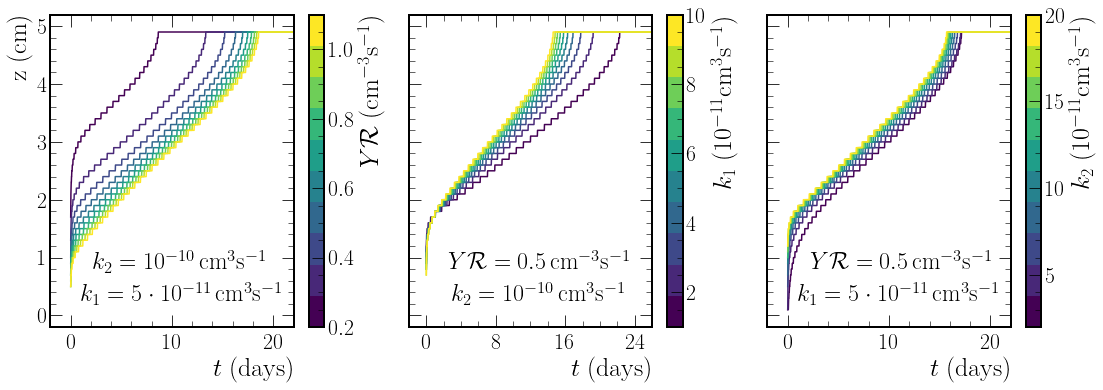

In [4]:
def plot_sim(D, R_arr, k1_arr, k2_arr):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16, 6))

    N = len(R_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    k1 = 0.05
    k2 = 0.1
    for R in R_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax1.plot(times, maximum)
    scale = 0.001
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=R_arr[0] / scale, vmax=R_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        ax=ax1,
        label=r"$Y\mathcal{R}$ $(\mathrm{cm}^{-3}\mathrm{s}^{-1})$",
        orientation="vertical",
    )
    ax1.set_xlim(-2, 22)
    ax1.set_ylim(-0.2, 5.2)
    ax1.set_xlabel(r"$t$ $(\mathrm{days})$")
    ax1.set_ylabel(r"$\mathrm{z}$ $(\mathrm{cm})$")
    ax1.text(2.2, 0.8, r"$k_2=10^{-10}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=24)
    ax1.text(
        1, 0.25, r"$k_1=5\cdot10^{-11}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=24
    )

    N = len(k1_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    R = 0.0005
    k2 = 0.1
    for k1 in k1_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax2.plot(times, maximum)
    scale = 0.01
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=k1_arr[0] / scale, vmax=k1_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        ax=ax2,
        label=r"$k_1$ $(10^{-11}\mathrm{cm}^{3}\mathrm{s}^{-1})$",
        orientation="vertical",
    )
    ax2.xaxis.set_major_locator(MultipleLocator(8))
    ax2.xaxis.set_minor_locator(MultipleLocator(2))
    ax2.set_xlim(-2, 26)
    ax2.set_ylim(-0.2, 5.2)
    ax2.set_xlabel(r"$t$ $(\mathrm{days})$")
    # ax2.set_ylabel("z (a.u.)")
    ax2.text(
        2.5, 0.8, r"$Y\mathcal{R}=0.5\,\mathrm{cm}^{-3}\mathrm{s}^{-1}$", fontsize=24
    )
    ax2.text(3, 0.25, r"$k_2=10^{-10}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=24)
    ax2.tick_params(labelleft=False)

    N = len(k2_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    R = 0.0005
    k1 = 0.05
    for k2 in k2_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax3.plot(times, maximum)
    scale = 0.01
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=k2_arr[0] / scale, vmax=k2_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        ax=ax3,
        label=r"$k_2$ $(10^{-11}\mathrm{cm}^{3}\mathrm{s}^{-1})$",
        orientation="vertical",
    )
    ax3.set_xlim(-2, 22)
    ax3.set_ylim(-0.2, 5.2)
    ax3.set_xlabel(r"$t$ $(\mathrm{days})$")
    # ax3.set_ylabel("z (a.u.)")
    ax3.text(
        2.2, 0.8, r"$Y\mathcal{R}=0.5\,\mathrm{cm}^{-3}\mathrm{s}^{-1}$", fontsize=24
    )
    ax3.text(
        1, 0.25, r"$k_1=5\cdot10^{-11}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=24
    )
    ax3.tick_params(labelleft=False)

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.18)
    plt.savefig("../plots/simulation.pdf", bbox_inches="tight")
    plt.show()


D = 0.1
R_arr = [round(0.0001 * i, 4) for i in range(2, 12)]
k1_arr = [round(0.01 * i, 4) for i in range(1, 11)]
k2_arr = [round(0.02 * i, 4) for i in range(1, 11)]
plot_sim(D, R_arr, k1_arr, k2_arr)

Same plot but with y axis titles:

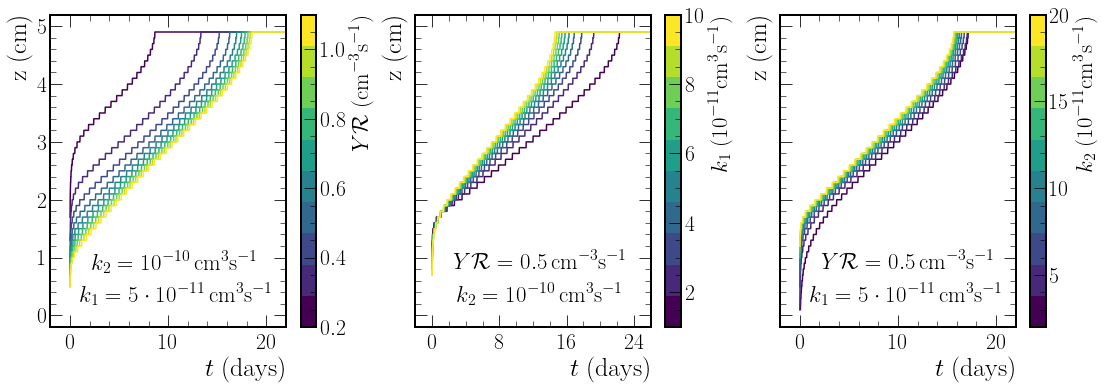

In [18]:
def plot_sim(D, R_arr, k1_arr, k2_arr):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16, 6))

    N = len(R_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    k1 = 0.05
    k2 = 0.1
    for R in R_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax1.plot(times, maximum)
    scale = 0.001
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=R_arr[0] / scale, vmax=R_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb1 = plt.colorbar(
        sm,
        ax=ax1,
        orientation="vertical",
    )
    cb1.set_label(label=r"$Y\mathcal{R}$ $(\mathrm{cm}^{-3}\mathrm{s}^{-1})$", size=23)
    ax1.set_xlim(-2, 22)
    ax1.set_ylim(-0.2, 5.2)
    ax1.set_xlabel(r"$t$ $(\mathrm{days})$")
    ax1.set_ylabel(r"$\mathrm{z}$ $(\mathrm{cm})$")
    ax1.text(2.2, 0.8, r"$k_2=10^{-10}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=23)
    ax1.text(
        1, 0.25, r"$k_1=5\cdot10^{-11}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=23
    )

    N = len(k1_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    R = 0.0005
    k2 = 0.1
    for k1 in k1_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax2.plot(times, maximum)
    scale = 0.01
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=k1_arr[0] / scale, vmax=k1_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb2 = plt.colorbar(
        sm,
        ax=ax2,
        orientation="vertical",
    )
    cb2.set_label(label=r"$k_1$ $(10^{-11}\mathrm{cm}^{3}\mathrm{s}^{-1})$", size=23)
    ax2.xaxis.set_major_locator(MultipleLocator(8))
    ax2.xaxis.set_minor_locator(MultipleLocator(2))
    ax2.set_xlim(-2, 26)
    ax2.set_ylim(-0.2, 5.2)
    ax2.set_xlabel(r"$t$ $(\mathrm{days})$")
    ax2.set_ylabel(r"$\mathrm{z}$ $(\mathrm{cm})$")
    ax2.text(
        2.5, 0.8, r"$Y\mathcal{R}=0.5\,\mathrm{cm}^{-3}\mathrm{s}^{-1}$", fontsize=23
    )
    ax2.text(3, 0.25, r"$k_2=10^{-10}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=23)
    ax2.tick_params(labelleft=False)

    N = len(k2_arr)
    color_cycle = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, N)))
    plt.rcParams["axes.prop_cycle"] = color_cycle
    R = 0.0005
    k1 = 0.05
    for k2 in k2_arr:
        filename = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
        maximum = np.load(f"../data/sim_{filename}.npy")
        times = np.linspace(0, 99.99, 9999)
        ax3.plot(times, maximum)
    scale = 0.01
    cmap = plt.get_cmap("viridis", N)
    norm = colors.Normalize(vmin=k2_arr[0] / scale, vmax=k2_arr[-1] / scale)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb3 = plt.colorbar(sm, ax=ax3, orientation="vertical")
    cb3.set_label(label=r"$k_2$ $(10^{-11}\mathrm{cm}^{3}\mathrm{s}^{-1})$", size=23)
    ax3.set_xlim(-2, 22)
    ax3.set_ylim(-0.2, 5.2)
    ax3.set_xlabel(r"$t$ $(\mathrm{days})$")
    ax3.set_ylabel(r"$\mathrm{z}$ $(\mathrm{cm})$")
    ax3.text(
        2.2, 0.8, r"$Y\mathcal{R}=0.5\,\mathrm{cm}^{-3}\mathrm{s}^{-1}$", fontsize=23
    )
    ax3.text(
        1, 0.25, r"$k_1=5\cdot10^{-11}\,\mathrm{cm}^{3}\mathrm{s}^{-1}$", fontsize=23
    )
    ax3.tick_params(labelleft=False)

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.24)
    plt.savefig("../plots/fig5_simulation.pdf", bbox_inches="tight")
    plt.show()


D = 0.1
R_arr = [round(0.0001 * i, 4) for i in range(2, 12)]
k1_arr = [round(0.01 * i, 4) for i in range(1, 11)]
k2_arr = [round(0.02 * i, 4) for i in range(1, 11)]
plot_sim(D, R_arr, k1_arr, k2_arr)